In [1]:
import sys, os
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import numpy as np
from plot_helpers import *
from src.util import *

# Mackey-Glass System

## Hopf Bifurcation

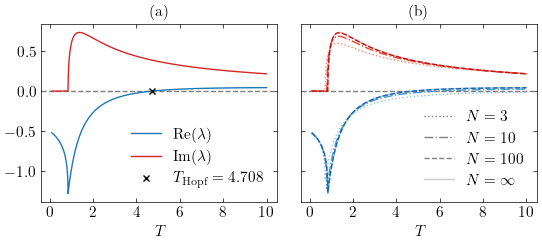

In [4]:
from src.system import *
from src.linear_stability import *
# Definitions
dde_Ts = np.linspace(.1, 10, 5000)
ode_Ts = np.linspace(.1, 10, 1000) # faster computation, less accurate
Ns = [3, 10, 100]
cm_vals = np.linspace(0.4, 0.8, len(Ns))
linestyles = [':', '-.', '--']
# DDE data
dde_ps, dde_qs, p_err, q_err = solve_char_eq(mackey_glass_char_eq, dde_Ts, initial_guess=(-.5, .01), ret_err=True)
T_c = mackey_glass_T_hopf()
# Construct plot
fig, (lax, rax) = plt.subplots(figsize=scale_fig(8,3,.8), nrows=1, ncols=2, sharey=True)
fig.subplots_adjust(wspace=.1)
lax.set(
    title='(a)',
    xlabel='$T$', xticks=np.arange(0, 11, 2),
    box_aspect=3/4
)
rax.set(
    title='(b)',
    xlabel='$T$', xticks=np.arange(0, 11, 2),
    box_aspect=3/4
)
# Labels and lines
hline(lax, 0)
hline(rax, 0)
# Plot left side
lax.plot(dde_Ts, dde_ps, label=r'Re($\lambda$)', color='tab:blue')
lax.plot(dde_Ts, dde_qs, label=r'Im($\lambda$)', color='tab:red')
point(lax, T_c, 0, marker='x', color='black',  label=r'$T_\text{Hopf} = %.3f$' % T_c)
lax.legend()
# Calculate and plot right side
rax.plot(dde_Ts, dde_ps, color='tab:blue', alpha=.4)
rax.plot(dde_Ts, dde_qs, color='tab:red', alpha=.4)
for N, cm_val, ls in zip(Ns, cm_vals, linestyles):
    alam = ode_jacobian_eigs(lambda T: mackey_glass_ksf_jacobian(N, T, MG_nontriv_FP), ode_Ts)[-1]
    ap, aq = alam.real, alam.imag
    rax.plot(ode_Ts, ap, color=plt.cm.Blues(cm_val), linestyle=ls)
    ###
    rax.plot(ode_Ts, aq, color=plt.cm.Reds(cm_val), linestyle=ls)
# Right side legend
from matplotlib.lines import Line2D
legend_lines = [Line2D([0], [0], color='grey', linestyle=ls) for ls in linestyles]+[Line2D([0], [0], color='grey', linestyle='-', alpha=.4)]
rax.legend(legend_lines, [r'$N=%d$'%n for n in Ns]+[r'$N=\infty$'])
# Save
fig.savefig('../img/mackey_glass/hopf_bifurcation', dpi=500)

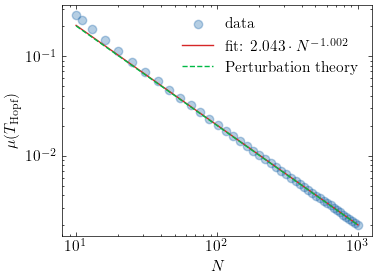

In [7]:
from scipy.optimize import curve_fit
from src.system import *
from src.linear_stability import *
# Data
# Ns = np.array(spaced_ints(10, 1000))
# ode_T_hopfs = np.array([ode_find_hopf_point_bisec(lambda T: mackey_glass_ksf_jacobian(N, T, MG_nontriv_FP), 3.4, 6, tol=1e-4) for N in Ns])
Ns, ode_T_hopfs = np.loadtxt('../data/mackey_glass/hopf_bifurcation.dat')
dde_T_hopf = mackey_glass_T_hopf()
mus = np.abs((ode_T_hopfs - dde_T_hopf) / dde_T_hopf)

# Fit
asymp_idx, = np.where(Ns > 300)
popt, pcov = curve_fit(power_law, Ns[asymp_idx], mus[asymp_idx], absolute_sigma=0)
# Perturbation Theory
def mu_pt(N):
    pt_T_hopf = 9.458 * 1/N + dde_T_hopf
    return np.abs((pt_T_hopf - dde_T_hopf) / (dde_T_hopf))
# Plot
fig, ax = plt.subplots(figsize=(4,3))
ax.set(
    xlabel=r'$N$', ylabel=r'$\mu(T_\text{Hopf})$',
    xscale='log', yscale='log',
)
ax.plot(Ns, mus, linestyle='None', marker='o', alpha=.3, label='data')
ax.plot(
    Ns, power_law(Ns, *popt), color='tab:red',
    label=r'fit: $%.3f \cdot N^{-%.3f}$' % tuple(popt),
    # linewidth=3
)
ax.plot(Ns, mu_pt(Ns), label='Perturbation theory', linestyle='--')
ax.legend()
fig.savefig('../img/mackey_glass/hopf_rel_err', dpi=500)

## Attractor

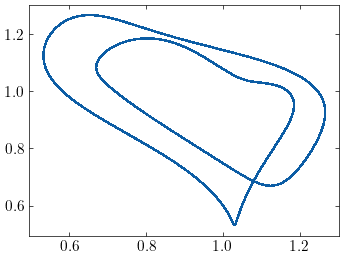

In [6]:
from src.system import mackey_glass_dde_jitc
from src.solver import dde_solver
T, m, t_max = 14, 100, 1e5
ts, traj = kill_transients(*dde_solver(mackey_glass_dde_jitc(T), T, m, t_max))
x0, xN = x_over_xT(traj, m=m)
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(x0, xN)

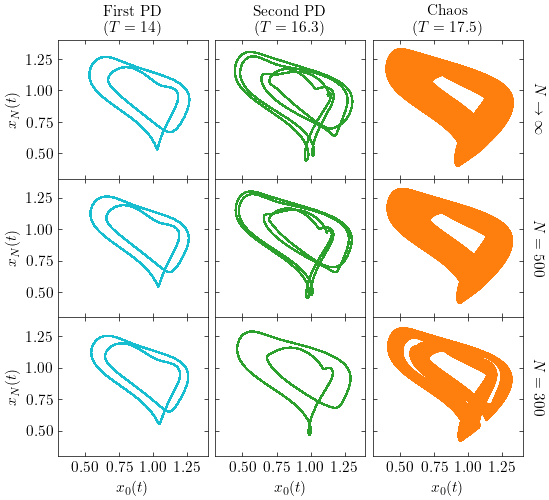

In [2]:
from src.solver import dde_solver, ode_solver
from src.system import mackey_glass_dde_jitc, mackey_glass_ksf_jitc

# Parameters
m, Ts, t_max = 100, [14, 16.3, 17.5], 5e4
# Plot
fig, axs = plt.subplots(3, 3, figsize=scale_fig(10, 9, .6), sharex=True, sharey=True)
# fig, axs = plt.subplots(3, 3, figsize=(8,6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=.05)
titles = [f'First PD\n($T = {Ts[0]}$)', f'Second PD\n($T = {Ts[1]}$)', f'Chaos\n($T = {Ts[2]}$)']
colors = ['tab:cyan', 'tab:green', 'tab:orange']
# First row
for t, c, T, ax in zip(titles, colors, Ts, axs[0,:]):
    ax.set_title(t, fontweight='bold')
    ts, traj = kill_transients(*dde_solver(mackey_glass_dde_jitc(T), T, m, t_max))
    ax.plot(*x_over_xT(traj, m=m), color=c)
# Second row
for c, T, ax in zip(colors, Ts, axs[1, :]):
    ts, traj = kill_transients(*ode_solver(mackey_glass_ksf_jitc(500, T), T, m, t_max))
    ax.plot(*x_over_xT(traj), color=c)
# Third row
for c, T, ax in zip(colors, Ts, axs[2, :]):
    ts, traj = kill_transients(*ode_solver(mackey_glass_ksf_jitc(300, T), T, m, t_max))
    ax.plot(*x_over_xT(traj), color=c)
    ax.set_xlabel(r'$x_0(t)$')
    ax.set_xticks([.5, .75, 1., 1.25])
    ax.set_xlim((.3, 1.4))
# First col
for ax in axs[:, 0]:
    ax.set_ylabel(r'$x_N(t)$')
    ax.set_yticks([.5, .75, 1., 1.25])
    ax.set_ylim((.3, 1.4))
# Right side labels for approximation order
N_labels = [r'$N \to \infty$', '$N = 500$', '$N = 300$']
for labl, ax in zip(N_labels, axs[:,2]):
    ax.annotate(labl, xy=(1.1, .5), xytext=(0, 0),
        xycoords='axes fraction', textcoords='offset points',
        fontweight='bold', ha='center', va='center', rotation=-90)
fig.savefig('../img/mackey_glass/attractors', dpi=500)

## Period Doubling

In [3]:
from src.period_doubling import dde_find_pd_bisec
from src.system import mackey_glass_dde_jitc

dde_find_pd_bisec(mackey_glass_dde_jitc, 100, 1e5, 12, 14)
dde_find_pd_bisec(mackey_glass_dde_jitc, 100, 1e5, 14, 17)

13.384246826171875

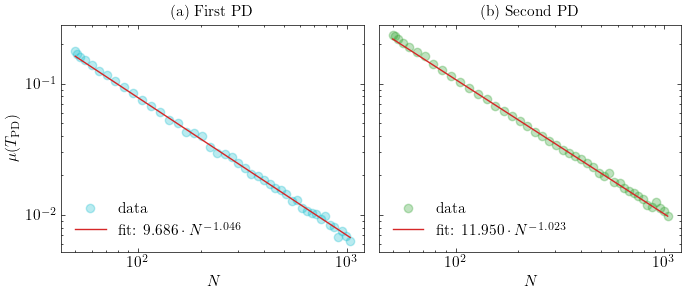

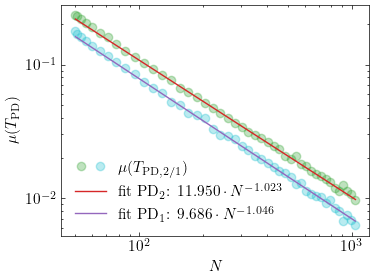

In [5]:
from scipy.optimize import curve_fit

# Load data
Ns, ode_pd1s, ode_pd2s = np.loadtxt('../data/mackey_glass/period_doublings.dat')
dde_pd1 = 13.389617919921875; dde_pd2 = 15.949920654296875
mu1s = np.abs((ode_pd1s - dde_pd1) / dde_pd1)
mu2s = np.abs((ode_pd2s - dde_pd2) / dde_pd2)
# Fit
asymp_idx, = np.where(Ns > 100)
popt1, _ = curve_fit(power_law, Ns[asymp_idx], mu1s[asymp_idx], absolute_sigma=0)
popt2, _ = curve_fit(power_law, Ns[asymp_idx], mu2s[asymp_idx], absolute_sigma=0)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3), sharey=True)
fig.subplots_adjust(wspace=.05)
ax1.set(
    xlabel=r'$N$', ylabel=r'$\mu(T_\text{PD})$',
    xscale='log', yscale='log',
    title='(a) First PD',
    box_aspect=3/4
)
ax2.set(
    xlabel=r'$N$',
    xscale='log', yscale='log',
    title='(b) Second PD',
    box_aspect=3/4
)
ax1.plot(Ns, mu1s, color='tab:cyan', linestyle='None', marker='o', alpha=.3, label='data')
ax1.plot(
    Ns, power_law(Ns, *popt1), color='tab:red',
    label=r'fit: $%.3f \cdot N^{-%.3f}$' % tuple(popt1)
)
ax1.legend(loc='lower left')
ax2.plot(Ns, mu2s, color='tab:green', linestyle='None', marker='o', alpha=.3, label='data')
ax2.plot(
    Ns, power_law(Ns, *popt2), color='tab:red',
    label=r'fit: $%.3f \cdot N^{-%.3f}$' % tuple(popt2)
)
ax2.legend(loc='lower left')
fig.savefig('../img/mackey_glass/period_doublings', dpi=500)

###########################
# Plot
fig, ax2 = plt.subplots(figsize=(4,3))
ax2.set(
    xlabel=r'$N$', ylabel=r'$\mu(T_\mathrm{PD})$',
    xscale='log', yscale='log',
    box_aspect=3/4
)
pl_pd1, = ax2.plot(Ns, mu1s, color='tab:cyan', linestyle='None', marker='o', alpha=.3, label='data PD1')
pl_pdfit1, = ax2.plot(
    Ns, power_law(Ns, *popt1), color='tab:purple',
    label=r'fit PD1: $%.3f \cdot N^{-%.3f}$' % tuple(popt1)
)
pl_pd2, = ax2.plot(Ns, mu2s, color='tab:green', linestyle='None', marker='o', alpha=.3, label='data PD2')
pl_pdfit2, = ax2.plot(
    Ns, power_law(Ns, *popt2), color='tab:red',
    label=r'fit PD2: $%.3f \cdot N^{-%.3f}$' % tuple(popt2)
)
from matplotlib.legend_handler import HandlerTuple
ax2.legend(
    [(pl_pd2, pl_pd1), pl_pdfit2, pl_pdfit1],
    [
        r'$\mu(T_\mathrm{PD,2/1})$',
        r'fit PD$_2$: $%.3f \cdot N^{-%.3f}$' % tuple(popt2),
        r'fit PD$_1$: $%.3f \cdot N^{-%.3f}$' % tuple(popt1)
    ],
    handler_map={tuple: HandlerTuple(ndivide=None)},
    loc='lower left'
)
fig.savefig('../img/mackey_glass/poster_period_doublings.pdf', dpi=500)

## Wernecke Test

0 5 10 15 20 25 30 35 40 45 

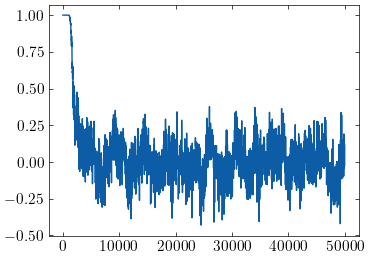

In [7]:
from src.system import mackey_glass_dde_flow, mackey_glass_dde_jitc
from src.wernecke_test import dde_cross_correlation

T = 17.3; delta = 10**(-6); m = 100; t_max = 5e4
ts, ds = dde_cross_correlation(mackey_glass_dde_flow, mackey_glass_dde_jitc(T), T, delta, m, t_max, n_h0=50)
plt.plot(ts, ds)

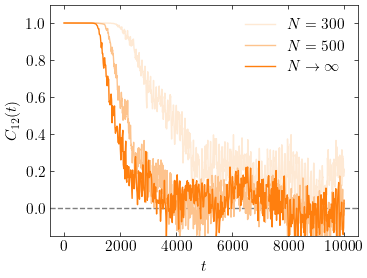

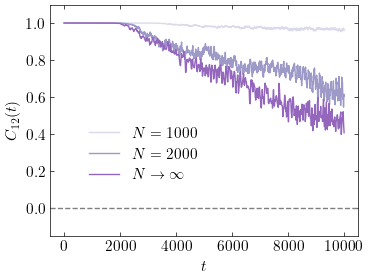

In [8]:
DATAPATH = '../data/mackey_glass/wernecke_test/'
fig, ax = plt.subplots(figsize=(4,3))
ax.set(
    ylim=(-0.15, 1.1),
    xlabel=r'$t$', ylabel=r'$C_{12}(t)$',
    box_aspect=3/4
)
hline(ax, 0)
ax.plot(
    *np.loadtxt(os.path.join(DATAPATH, 'Cn300T17c5.dat')),
    color=plt.cm.Oranges(0.1), label=r'$N = 300$'
)
ax.plot(
    *np.loadtxt(os.path.join(DATAPATH, 'Cn500T17c5.dat')),
    color=plt.cm.Oranges(0.3), label=r'$N = 500$'
)
ax.plot(
    *np.loadtxt(os.path.join(DATAPATH, 'CddeT17c5.dat')),
    color='tab:orange', label=r'$N \to \infty$'
)
ax.legend()
fig.savefig('../img/mackey_glass/wernecke_test_chaos', dpi=500)

fig, ax = plt.subplots(figsize=(4,3))
ax.set(
    ylim=(-0.15, 1.1),
    xlabel=r'$t$', ylabel=r'$C_{12}(t)$',
    box_aspect=3/4
)
hline(ax, 0)
ax.plot(
    *np.loadtxt(os.path.join(DATAPATH, 'Cn1000T16c7.dat')),
    color=plt.cm.Purples(0.25), label=r'$N = 1000$'
)
ax.plot(
    *np.loadtxt(os.path.join(DATAPATH, 'Cn2000T16c7.dat')),
    color=plt.cm.Purples(0.5), label=r'$N = 2000$'
)
ax.plot(
    *np.loadtxt(os.path.join(DATAPATH, 'CddeT16c7.dat')),
    color='tab:purple', label=r'$N \to \infty$'
)
ax.legend(loc='center', bbox_to_anchor=(0.3, 0.35))
# fig.savefig('../img/mackey_glass/wernecke_test')

## Lyapunov Exponents

In [11]:
from src.system import mackey_glass_dde_jitc, mackey_glass_ksf_jitc
from src.lyapunov_exponents import dde_lyap_spec, ode_lyap_spec

T = 17.5; m = 100; t_max = 5e4
dde_lyap_spec(mackey_glass_dde_jitc(T), T, m, t_max, print_est_err=1)
ode_lyap_spec(mackey_glass_ksf_jitc(500, T), T, m, t_max, print_est_err=1)

1. LE: 0.00700639 +/- 0.00008199
1. LE: 0.00598727 +/- 0.00009761


array([0.00598727])

Chaos breaks down at a kernel width (kernel m = N) of 1.3228756555322954


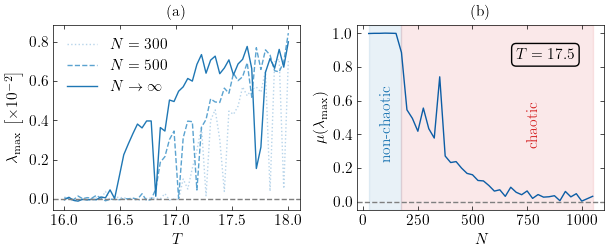

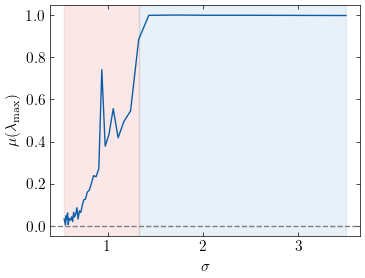

In [13]:
fig, (lax, rax) = plt.subplots(figsize=scale_fig(9,3,.8), nrows=1, ncols=2)
fig.subplots_adjust(wspace=0.2)
lax.set(
    title=r'(a)',
    xlabel=r'$T$', ylabel=r'$\lambda_\mathrm{max} \: \left[\times 10^{-2}\right]$',
    box_aspect=3/4
)
rax.set(
    title=r'(b)',
    xlabel=r'$N$', ylabel=r'$\mu(\lambda_\mathrm{max})$',
    yticks=[0, .2, .4, .6, .8, 1],
    box_aspect=3/4
)
# Plotting
ns = (300, 500)
cm_vals = np.linspace(0.3, 0.55, len(ns))
b_cs = (plt.cm.Blues(v) for v in cm_vals) # colors for ODE approximation
r_cs = (plt.cm.Reds(v) for v in cm_vals) # colors for ODE approximation
g_cs = (plt.cm.Greys(v) for v in cm_vals) # colors for legend
linestyles = [':', '--']
for n, bc, rc, ls in zip(ns, b_cs, r_cs, linestyles):
    Tls, Trs, laml1s, laml2s, lamr1s, lamr2s = np.loadtxt(f'../data/mackey_glass/lyapunov_exponents/{n}ode_2LEs.dat')
    lax.plot(Tls, laml1s/0.01, color=bc, label=r'$N = %d$'%n, linestyle=ls)
dde_Tls, dde_Trs, dde_laml1s, dde_laml2s, dde_lamr1s, dde_lamr2s = np.loadtxt('../data/mackey_glass/lyapunov_exponents/dde_2LEs.dat')
lax.plot(dde_Tls, dde_laml1s/0.01, color='tab:blue', label=r'$N \to \infty$')
lax.legend()
hline(lax, 0)
Ns, lambs = np.loadtxt('../data/mackey_glass/lyapunov_exponents/T17c5_mLE_ode_dde_full_new.dat')
widths = 17.5/np.sqrt(Ns)
i = np.where(lambs>0.0001)[0][0]
lamb_max_MG = 0.00714070
mus = np.abs(lambs - lamb_max_MG) / np.abs(lamb_max_MG)
rax.axvspan(Ns[0], Ns[i], color='tab:blue', alpha=.1)
rax.axvspan(Ns[i], Ns[-1], color='tab:red', alpha=.1)
rax.text(80, 0.25, 'non-chaotic', color='tab:blue', rotation='vertical')
rax.text(750, 0.33, 'chaotic', color='tab:red', rotation='vertical')
rax.text(700, 0.85, r'$T = 17.5$', color='black', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=.3'))
# rax.fill_between((0, Ns[i])
# rax.axvspan(Ns[i], 1000)
rax.plot(Ns, mus)
hline(rax,0)
fig.savefig('../img/mackey_glass/lyapunov_exponents', dpi=500)
# fig.savefig('../img/mackey_glass/lyapunov_exponents_new.pdf', dpi=500)
fig, ax = plt.subplots(figsize=(4,3))
ax.set(
    xlabel=r'$\sigma$', ylabel=r'$\mu(\lambda_\textrm{max})$',
)
ax.plot(widths, mus)
ax.axvspan(widths[0], widths[i], color='tab:blue', alpha=.1)
ax.axvspan(widths[i], widths[-1], color='tab:red', alpha=.1)
hline(ax, 0)
print(f'Chaos breaks down at a kernel width (kernel m = N) of {widths[i]}')